# Proprocessing

**Security DS - Proyecto 1**

Roberto Figueroa - 18306

Gustavo Méndez - 18500

## Preprocessing (12M+ records dataset)

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import reduce_memory_usage
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

%matplotlib inline
pd.set_option("display.max_columns", None)

**Load dataset and reduce memory usage**

In [83]:
# Load by chunks, due to dataset size (~4 GB if unzipped)
chunk_samples = []
CHUNK_SIZE = 10 ** 6

for chunk in pd.read_csv('./datasets/final_sample.csv.zip', index_col=[0], chunksize=CHUNK_SIZE):
    reduced_chunk = reduce_memory_usage(chunk, verbose=False)
    chunk_samples.append(reduced_chunk)
    
df = pd.concat(chunk_samples, ignore_index=True)
del chunk_samples

### EDA Recap

We have generated a 12M+ records datasets, with 4 different labels. The current label distribution is shown below: 

In [ ]:
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)


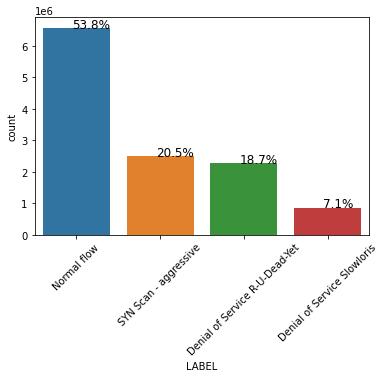

In [ ]:
ax = sns.countplot(x="LABEL", data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
without_hue(ax, df['LABEL'])

Clearly, we need to focus on dealing with label imbalance, but not before preprocessing the current data.

### Preprocess summary

**Columns to remove**

 ['BIFLOW_DIRECTION', 'FIREWALL_EVENT', 'FLOW_ACTIVE_TIMEOUT', 'FLOW_INACTIVE_TIMEOUT', 'FRAME_LENGTH', 'MAX_IP_PKT_LEN', 'MIN_IP_PKT_LEN', 'SAMPLING_INTERVAL', 'L7_PROTO_NAME', 'FLOW_START_SEC', 'FLOW_END_SEC', 'TCP_FLAGS']

**Encode and Feature Derivation**
- LABEL (OneHotEncode)
- PROTOCOL (Bin -> OneHotEncode)
- PROTOCOL_MAP (OneHotEncode)
- TOS [Type Of Service] (Bin Right Shift -> OneHotEncode)

**Normalization**
- Standard Scaling (avoided, resume it on data traning split)

**Data Balancing**
- Oversampling and Undersampling


### Remove colums

We are going to drop columns that have same value in all rows. Also this is important to flush some memory

In [84]:
df.drop(['BIFLOW_DIRECTION', 
          'FIREWALL_EVENT', 
          'FLOW_ACTIVE_TIMEOUT', 
          'FLOW_START_SEC',
          'FLOW_END_SEC',
          'FLOW_INACTIVE_TIMEOUT', 
          'FRAME_LENGTH', 
          'MAX_IP_PKT_LEN', 
          'MIN_IP_PKT_LEN', 
          'SAMPLING_INTERVAL',
          'L7_PROTO_NAME', 
          'IPV4_DST_ADDR',
          'IPV4_SRC_ADDR',
          'TCP_FLAGS',
          'DST_TO_SRC_SECOND_BYTES',
          'SRC_TO_DST_SECOND_BYTES',
          'FLOW_ID'
], axis=1, inplace=True)

### Encode and Feature Derivation

In [85]:
labelencoder = LabelEncoder()
df['LABEL'] = labelencoder.fit_transform(df['LABEL'])
df.head()

,DIRECTION,FIRST_SWITCHED,FLOW_DURATION_MICROSECONDS,FLOW_DURATION_MILLISECONDS,FLOW_END_MILLISECONDS,FLOW_START_MILLISECONDS,IN_BYTES,IN_PKTS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,OOORDER_IN_PKTS,OOORDER_OUT_PKTS,OUT_BYTES,OUT_PKTS,PROTOCOL,PROTOCOL_MAP,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,TCP_WIN_MIN_IN,TCP_WIN_MIN_OUT,TCP_WIN_MSS_IN,TCP_WIN_MSS_OUT,TCP_WIN_SCALE_IN,TCP_WIN_SCALE_OUT,SRC_TOS,DST_TOS,TOTAL_FLOWS_EXP,LABEL
0,0,1616660040,339,0,1616660040010,1616660040010,44,1,60541,22351,1616660040,0,0,40,1,6,tcp,0,0,0,0,1024,0,1024,0,1460,0,0,0,0,0,2293398,2
1,0,1616660040,0,0,1616660040068,1616660040068,68,1,0,0,1616660040,0,0,0,0,1,icmp,0,0,0,0,0,0,0,0,0,0,0,0,40,0,2293400,2
2,0,1616660040,44725,44,1616660040114,1616660040070,189,2,24650,443,1616660040,0,0,104,2,6,tcp,0,0,0,0,122,1634,122,1634,0,0,0,0,0,0,2293404,2
3,0,1616660040,0,0,1616660040122,1616660040122,52,1,8728,61075,1616660040,0,0,0,0,6,tcp,0,0,0,0,8192,0,8192,0,1440,0,8,0,40,0,2293407,2
4,0,1616660040,1114,1,1616660040184,1616660040183,189,2,443,39762,1616660040,0,0,40,1,6,tcp,0,0,0,0,502,0,502,0,0,0,0,0,0,0,2293409,2


In [86]:
print("\nLabel ID 0 for: ")
print(df[df['LABEL'] == 0].head(1)['LABEL']) #Denial of Service R-U-Dead-Yet
print("\nLabel ID 1 for: ")
print(df[df['LABEL'] == 1].head(1)['LABEL']) #Denial of Service Slowloris
print("\nLabel ID 2 for: ")
print(df[df['LABEL'] == 2].head(1)['LABEL']) #Normal flow
print("\nLabel ID 3 for: ")
print(df[df['LABEL'] == 3].head(1)['LABEL']) #SYN Scan - aggressive


Label ID 0 for: 
6213351    0
Name: LABEL, dtype: int64

Label ID 1 for: 
9826306    1
Name: LABEL, dtype: int64

Label ID 2 for: 
0    2
Name: LABEL, dtype: int64

Label ID 3 for: 
3060    3
Name: LABEL, dtype: int64


In [87]:
protocol_array = df['PROTOCOL'].apply(lambda x : format(x, "b").zfill(6)).to_numpy(dtype=object)
protocol_array = np.array([list(binary) for binary in protocol_array])
df_protocol = pd.DataFrame(protocol_array, columns=["URG", "ACK", "PSH", "RST", "SYN", "FIN"])

df = pd.concat([df, df_protocol], axis=1)
# df.drop("PROTOCOL", axis=1, inplace=True)

del protocol_array
del df_protocol

df.head()

,DIRECTION,FIRST_SWITCHED,FLOW_DURATION_MICROSECONDS,FLOW_DURATION_MILLISECONDS,FLOW_END_MILLISECONDS,FLOW_START_MILLISECONDS,IN_BYTES,IN_PKTS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,OOORDER_IN_PKTS,OOORDER_OUT_PKTS,OUT_BYTES,OUT_PKTS,PROTOCOL,PROTOCOL_MAP,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,TCP_WIN_MIN_IN,TCP_WIN_MIN_OUT,TCP_WIN_MSS_IN,TCP_WIN_MSS_OUT,TCP_WIN_SCALE_IN,TCP_WIN_SCALE_OUT,SRC_TOS,DST_TOS,TOTAL_FLOWS_EXP,LABEL,URG,ACK,PSH,RST,SYN,FIN
0,0,1616660040,339,0,1616660040010,1616660040010,44,1,60541,22351,1616660040,0,0,40,1,6,tcp,0,0,0,0,1024,0,1024,0,1460,0,0,0,0,0,2293398,2,0,0,0,1,1,0
1,0,1616660040,0,0,1616660040068,1616660040068,68,1,0,0,1616660040,0,0,0,0,1,icmp,0,0,0,0,0,0,0,0,0,0,0,0,40,0,2293400,2,0,0,0,0,0,1
2,0,1616660040,44725,44,1616660040114,1616660040070,189,2,24650,443,1616660040,0,0,104,2,6,tcp,0,0,0,0,122,1634,122,1634,0,0,0,0,0,0,2293404,2,0,0,0,1,1,0
3,0,1616660040,0,0,1616660040122,1616660040122,52,1,8728,61075,1616660040,0,0,0,0,6,tcp,0,0,0,0,8192,0,8192,0,1440,0,8,0,40,0,2293407,2,0,0,0,1,1,0
4,0,1616660040,1114,1,1616660040184,1616660040183,189,2,443,39762,1616660040,0,0,40,1,6,tcp,0,0,0,0,502,0,502,0,0,0,0,0,0,0,2293409,2,0,0,0,1,1,0


In [88]:
# Memory optimization
df.astype({"URG": np.uint8, 
                "ACK": np.uint8,
               "PSH": np.uint8, 
               "RST": np.uint8,
               "SYN": np.uint8,
               "FIN": np.uint8}, copy=False)


,DIRECTION,FIRST_SWITCHED,FLOW_DURATION_MICROSECONDS,FLOW_DURATION_MILLISECONDS,FLOW_END_MILLISECONDS,FLOW_START_MILLISECONDS,IN_BYTES,IN_PKTS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,OOORDER_IN_PKTS,OOORDER_OUT_PKTS,OUT_BYTES,OUT_PKTS,PROTOCOL,PROTOCOL_MAP,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,TCP_WIN_MIN_IN,TCP_WIN_MIN_OUT,TCP_WIN_MSS_IN,TCP_WIN_MSS_OUT,TCP_WIN_SCALE_IN,TCP_WIN_SCALE_OUT,SRC_TOS,DST_TOS,TOTAL_FLOWS_EXP,LABEL,URG,ACK,PSH,RST,SYN,FIN
0,0,1616660040,339,0,1616660040010,1616660040010,44,1,60541,22351,1616660040,0,0,40,1,6,tcp,0,0,0,0,1024,0,1024,0,1460,0,0,0,0,0,2293398,2,0,0,0,1,1,0
1,0,1616660040,0,0,1616660040068,1616660040068,68,1,0,0,1616660040,0,0,0,0,1,icmp,0,0,0,0,0,0,0,0,0,0,0,0,40,0,2293400,2,0,0,0,0,0,1
2,0,1616660040,44725,44,1616660040114,1616660040070,189,2,24650,443,1616660040,0,0,104,2,6,tcp,0,0,0,0,122,1634,122,1634,0,0,0,0,0,0,2293404,2,0,0,0,1,1,0
3,0,1616660040,0,0,1616660040122,1616660040122,52,1,8728,61075,1616660040,0,0,0,0,6,tcp,0,0,0,0,8192,0,8192,0,1440,0,8,0,40,0,2293407,2,0,0,0,1,1,0
4,0,1616660040,1114,1,1616660040184,1616660040183,189,2,443,39762,1616660040,0,0,40,1,6,tcp,0,0,0,0,502,0,502,0,0,0,0,0,0,0,2293409,2,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12207868,0,1618262463,14015728,14015,1618262477935,1618262463919,240,4,53,39394,1618262477,0,0,480,4,17,udp,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85888693,2,0,1,0,0,0,1
12207869,0,1618262477,0,0,1618262477940,1618262477940,40,1,3446,55411,1618262477,0,0,0,0,6,tcp,0,0,0,0,1024,0,1024,0,0,0,0,0,40,0,85888694,2,0,0,0,1,1,0
12207870,0,1618262473,4921754,4921,1618262477954,1618262473032,1345,12,22,39140,1618262477,0,0,2127,14,6,tcp,0,0,0,0,29200,27960,29200,27960,1460,1410,7,7,40,0,85888695,2,0,0,0,1,1,0
12207871,0,1618262477,376,0,1618262477977,1618262477977,88,1,53,4319,1618262477,0,0,205,1,17,udp,0,0,0,0,0,0,0,0,0,0,0,0,128,0,85888696,2,0,1,0,0,0,1


In [89]:
protocol_map_df = pd.get_dummies(df["PROTOCOL_MAP"], columns=["PROTOCOL_MAP"])
df = pd.concat([df, protocol_map_df], axis=1)
df.drop("PROTOCOL_MAP", axis=1, inplace=True)

del protocol_map_df

df.head()

,DIRECTION,FIRST_SWITCHED,FLOW_DURATION_MICROSECONDS,FLOW_DURATION_MILLISECONDS,FLOW_END_MILLISECONDS,FLOW_START_MILLISECONDS,IN_BYTES,IN_PKTS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,OOORDER_IN_PKTS,OOORDER_OUT_PKTS,OUT_BYTES,OUT_PKTS,PROTOCOL,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,TCP_WIN_MIN_IN,TCP_WIN_MIN_OUT,TCP_WIN_MSS_IN,TCP_WIN_MSS_OUT,TCP_WIN_SCALE_IN,TCP_WIN_SCALE_OUT,SRC_TOS,DST_TOS,TOTAL_FLOWS_EXP,LABEL,URG,ACK,PSH,RST,SYN,FIN,gre,icmp,ipv6-icmp,tcp,udp
0,0,1616660040,339,0,1616660040010,1616660040010,44,1,60541,22351,1616660040,0,0,40,1,6,0,0,0,0,1024,0,1024,0,1460,0,0,0,0,0,2293398,2,0,0,0,1,1,0,0,0,0,1,0
1,0,1616660040,0,0,1616660040068,1616660040068,68,1,0,0,1616660040,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,40,0,2293400,2,0,0,0,0,0,1,0,1,0,0,0
2,0,1616660040,44725,44,1616660040114,1616660040070,189,2,24650,443,1616660040,0,0,104,2,6,0,0,0,0,122,1634,122,1634,0,0,0,0,0,0,2293404,2,0,0,0,1,1,0,0,0,0,1,0
3,0,1616660040,0,0,1616660040122,1616660040122,52,1,8728,61075,1616660040,0,0,0,0,6,0,0,0,0,8192,0,8192,0,1440,0,8,0,40,0,2293407,2,0,0,0,1,1,0,0,0,0,1,0
4,0,1616660040,1114,1,1616660040184,1616660040183,189,2,443,39762,1616660040,0,0,40,1,6,0,0,0,0,502,0,502,0,0,0,0,0,0,0,2293409,2,0,0,0,1,1,0,0,0,0,1,0


In [90]:
# TOS - Type Of Service, extract Precedence (datagram/packet importance)

# Right Shift 5: extract only the 3 left bits, Precedence will go from 0 to 7 now
df['SRC_PKT_PRECEDENCE'] = df['SRC_TOS'].apply(lambda x : x >> 5)
df['DST_PKT_PRECEDENCE'] = df['DST_TOS'].apply(lambda x : x >> 5)
df.astype({
    "SRC_PKT_PRECEDENCE": np.uint8, 
    "DST_PKT_PRECEDENCE": np.uint8
}, copy=False)

#df.drop(columns=["SRC_TOS", "DST_TOS"], axis=1, inplace=True)

# Check values from 0 - 7
print(df["DST_PKT_PRECEDENCE"].value_counts())
print(df["SRC_PKT_PRECEDENCE"].value_counts())

0    11232793
1      677660
5      206997
2       82138
3        4021
4        2571
6        1509
7         184
Name: DST_PKT_PRECEDENCE, dtype: int64
0    11008086
1      660459
5      262517
6      162541
2       98781
3       13655
4        1447
7         387
Name: SRC_PKT_PRECEDENCE, dtype: int64


### Data balancing

We are going to mix down-sampling with over-sampling in order to balance the dataset.

We are going to down-sample Normal Flow label until reach Denial of Service R-U-Dead-Yet label observations amount. 

We are going to over-sample Denial of Service Slowloris until reach Denial of Service R-U-Dead-Yet observations amount.

we are going to down-sample SYN Scan - aggressive until reach Denial of Service R-U-Dead-Yet observations amount.

In [91]:
# Separate majority and minority classes 
df_majority_n_flow = df[df['LABEL'] == 2]
df_minority_slowloris = df[df['LABEL'] == 1]
df_majority_syn_scan = df[df['LABEL'] == 3]
df_ddos_rydy = df[df['LABEL'] == 0]
n_samples_2_reach = df_ddos_rydy.shape[0]
del df

In [92]:
# Upsample minority class (slowloris)
df_minority_upsampled_n_flow = resample(df_majority_n_flow, 
                                 replace=True,
                                 n_samples=n_samples_2_reach,
                                 random_state=127)
del df_majority_n_flow

In [93]:
# Upsample minority class (slowloris)
df_majority_downsampled_slowloris = resample(df_minority_slowloris, 
                                 replace=True,
                                 n_samples=n_samples_2_reach,
                                 random_state=127)
del df_minority_slowloris

In [94]:

df_majority_downsampled_syn_scan = resample(df_majority_syn_scan, 
                                 replace=True,
                                 n_samples=n_samples_2_reach,
                                 random_state=127)
del df_majority_syn_scan

In [95]:

# Combine majority class with upsampled minority class
df = pd.concat([df_minority_upsampled_n_flow, 
                   df_majority_downsampled_slowloris,
                   df_majority_downsampled_syn_scan,
                   df_ddos_rydy])

df = reduce_memory_usage(df, verbose=True)

# Flush some memory
del df_minority_upsampled_n_flow
del df_majority_downsampled_slowloris
del df_majority_downsampled_syn_scan
del df_ddos_rydy



Mem. usage decreased to 1459.23 Mb (15.2% reduction)


<BarContainer object of 4 artists>

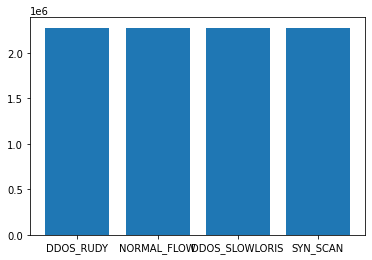

In [96]:
values = [df[df['LABEL'] == 0].shape[0],
    df[df['LABEL'] == 1].shape[0],
    df[df['LABEL'] == 2].shape[0],
    df[df['LABEL'] == 3].shape[0]]
names = ["DDOS_RUDY", "NORMAL_FLOW", "DDOS_SLOWLORIS", "SYN_SCAN"]
plt.bar(names, values)

## Feature Selection

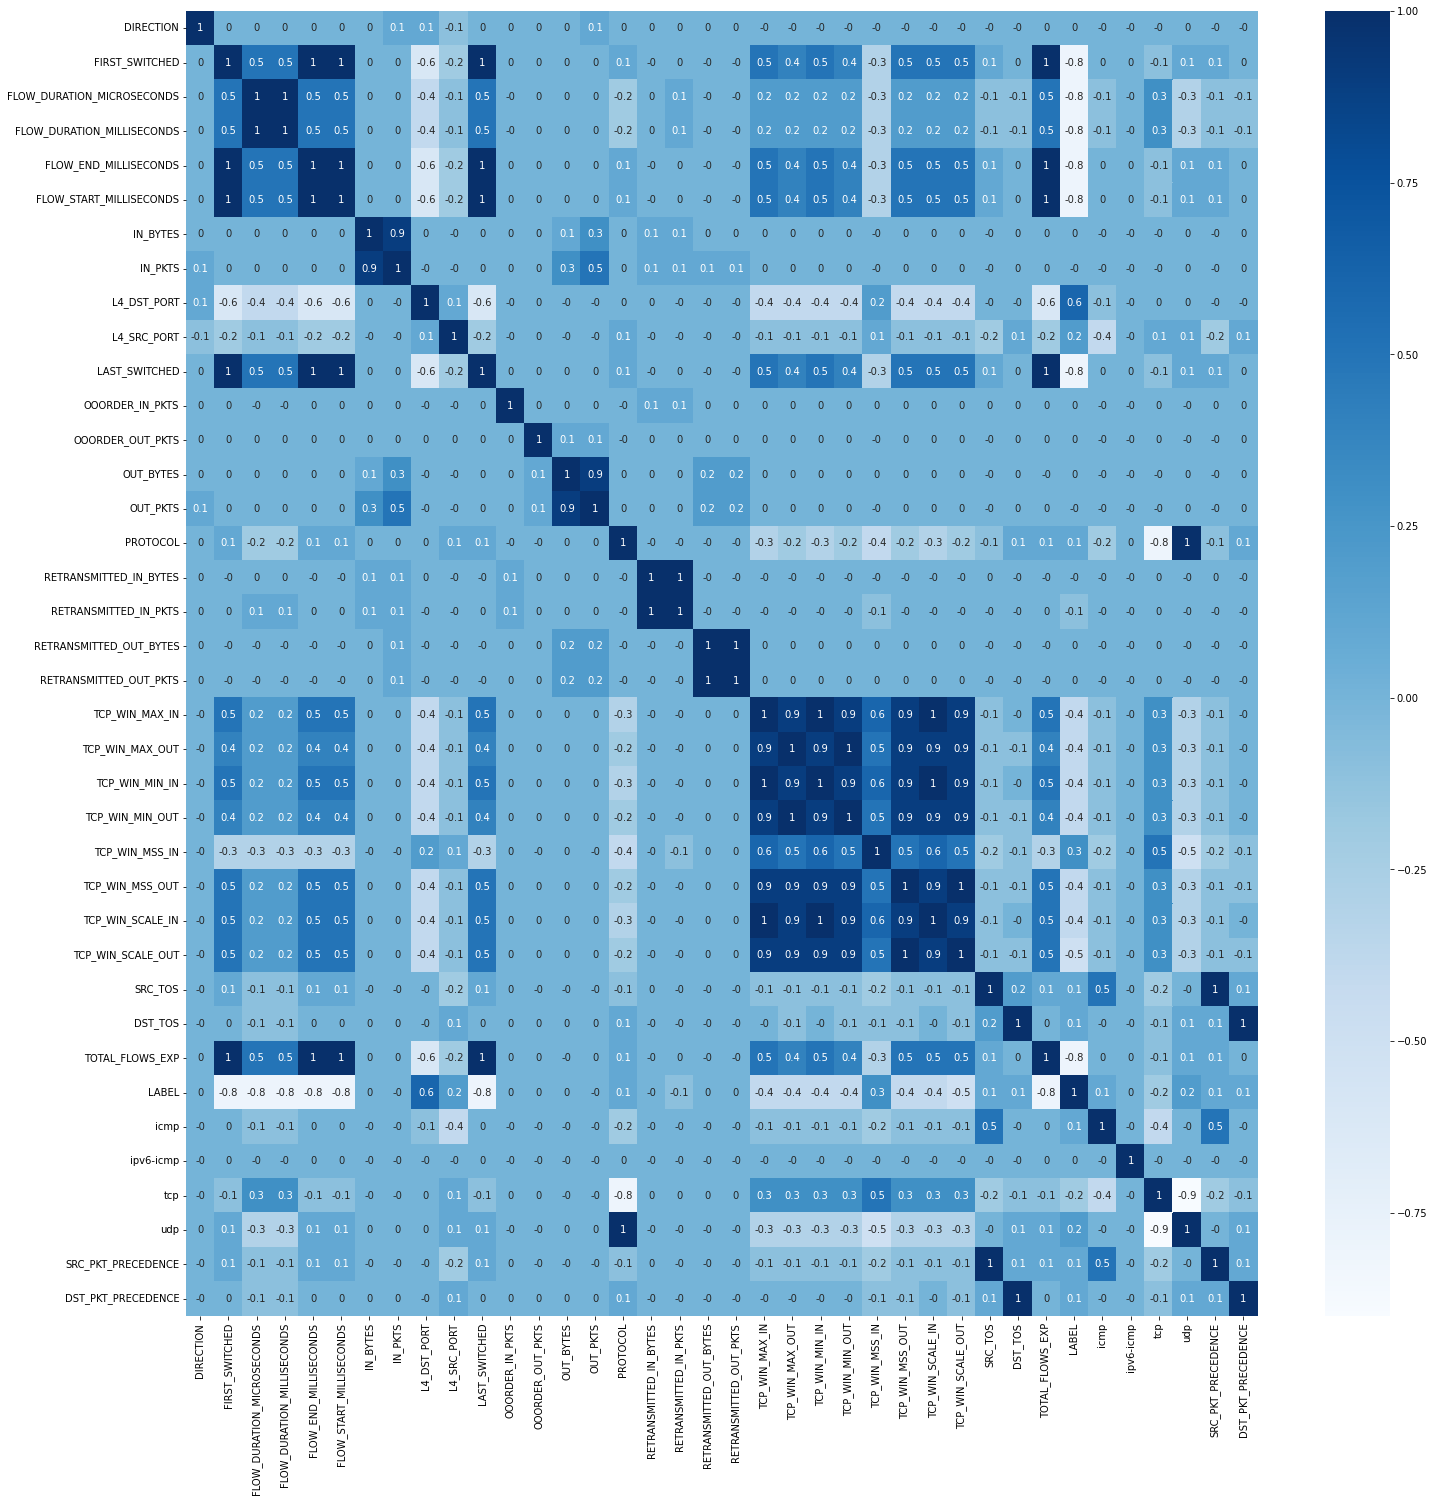

In [65]:
df.drop('gre', axis=1, inplace=True)
matrix_corr = df.corr(method='pearson').round(decimals=1)
plt.figure(figsize=(24, 24))
sns.heatmap(matrix_corr, annot=True, cmap="Blues")

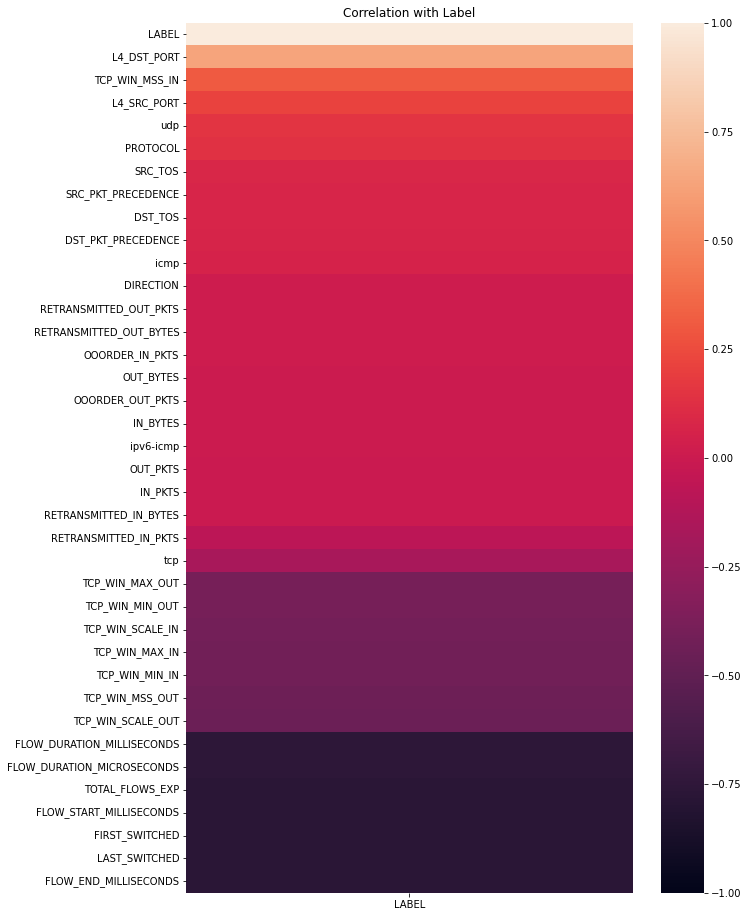

In [75]:
plt.figure(figsize=(10, 16))
full_correlations = df.corr()[['LABEL']].sort_values(by="LABEL", ascending=False)
# Most correlated variables with 'status'
hm = sns.heatmap(full_correlations, vmin=-1, vmax=1)
hm.set_title('Correlation with Label')
plt.show()

We are going to select those features that have high correlation values between our target features

In [81]:
# Correlation of 50% (lowest bound for us...)
CORR_COEFF = 0.1

most_correlated = full_correlations[full_correlations['LABEL'].abs() >= CORR_COEFF].abs()
# Sort and remove status from correlation list
most_correlated = most_correlated.sort_values(by='LABEL', ascending=False)
print(f"Correlation of {CORR_COEFF} with 'LABEL': \n", most_correlated)

Correlation of 0.1 with 'LABEL': 
                                LABEL
LABEL                       1.000000
FLOW_END_MILLISECONDS       0.780052
LAST_SWITCHED               0.780052
FIRST_SWITCHED              0.780031
FLOW_START_MILLISECONDS     0.780031
TOTAL_FLOWS_EXP             0.778581
FLOW_DURATION_MICROSECONDS  0.759758
FLOW_DURATION_MILLISECONDS  0.759757
L4_DST_PORT                 0.639229
TCP_WIN_SCALE_OUT           0.451872
TCP_WIN_MSS_OUT             0.440469
TCP_WIN_MIN_IN              0.420203
TCP_WIN_MAX_IN              0.419631
TCP_WIN_SCALE_IN            0.408654
TCP_WIN_MIN_OUT             0.393072
TCP_WIN_MAX_OUT             0.392697
TCP_WIN_MSS_IN              0.304720
L4_SRC_PORT                 0.217324
tcp                         0.168262
udp                         0.154180
PROTOCOL                    0.138624


In [97]:
# For protocol and dst_tos we made OneHotEncoding
high_corr_features = ['FIRST_SWITCHED', 
'FLOW_DURATION_MICROSECONDS', 
'L4_DST_PORT',
'L4_SRC_PORT',
'LAST_SWITCHED',
'TCP_WIN_MAX_IN',
'TCP_WIN_MAX_OUT',
'TCP_WIN_MIN_IN',
'TCP_WIN_MIN_OUT',
'TCP_WIN_MSS_IN',
'TCP_WIN_SCALE_OUT',
'TCP_WIN_SCALE_IN',
'TOTAL_FLOWS_EXP',
'tcp',
'udp',
'SRC_PKT_PRECEDENCE',
'DST_PKT_PRECEDENCE',
'URG',
'ACK',
'PSH',
'RST',
'SYN',
'FIN',
'LABEL']

In [72]:
df[high_corr_features]

,FIRST_SWITCHED,FLOW_DURATION_MICROSECONDS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,TCP_WIN_MIN_IN,TCP_WIN_MIN_OUT,TCP_WIN_MSS_IN,TCP_WIN_SCALE_OUT,TCP_WIN_SCALE_IN,TOTAL_FLOWS_EXP,tcp,udp,SRC_PKT_PRECEDENCE,DST_PKT_PRECEDENCE,URG,ACK,PSH,RST,SYN,FIN,LABEL
4196855,1618194298,59445,8760,53792,1618194298,1200,0,1024,0,0,0,0,77877680,1,0,5,5,0,0,0,1,1,0,2
3897706,1618185270,0,10704,47921,1618185270,0,0,0,0,0,0,0,77578531,0,1,0,0,0,1,0,0,0,1,2
6675935,1618225083,0,111,13084,1618225083,0,0,0,0,0,0,0,80356760,0,1,0,0,0,1,0,0,0,1,2
5856650,1618219151,211066,5083,55300,1618219152,1200,0,1024,0,0,0,0,79537475,1,0,1,0,0,0,0,1,1,0,2
4293970,1618197175,487414,0,0,1618197176,0,0,0,0,0,0,0,77974795,0,0,6,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9469365,1618233278,6984530,80,20618,1618233285,507,114,507,114,0,0,0,83150190,1,0,0,0,0,0,0,1,1,0,0
9469366,1618233283,1929656,80,27516,1618233285,64860,27960,64860,27960,1410,8,7,83150191,1,0,0,0,0,0,0,1,1,0,0
9469367,1618233268,16781202,80,56782,1618233285,507,114,507,114,0,0,0,83150192,1,0,0,0,0,0,0,1,1,0,0
9469368,1618233268,16784339,80,20494,1618233285,507,114,507,114,0,0,0,83150193,1,0,0,0,0,0,0,1,1,0,0


## Normalization

After we selected our features for the models implementation, we need to normalize our data!

In [98]:
# Standard Scaler only to some columns...


ignore_col_names = [
    'DIRECTION', 'FIRST_SWITCHED', 'FLOW_END_MILLISECONDS', 'FLOW_START_MILLISECONDS', 'LAST_SWITCHED',
    'SRC_PKT_PRECEDENCE', 'DST_PKT_PRECEDENCE', 'DDOS_RUDY', 'DDOS_SLOWLORIS', 'NORMAL_FLOW', 'SYN_SCAN', 
    'URG', 'ACK', 'PSH', 'RST', 'SYN', 'FIN', 
    'gre', 'icmp', 'ipv6-icmp', 'tcp', 'udp' , 'LABEL'    
]
features_to_scale = [val for val in list(df.columns) if val not in ignore_col_names]

# Chunks for memory usage optimization
x = 4
chunk_simple_list =  lambda my_list, x: [my_list[i:i+x] for i in range(0, len(my_list), x)]
chunked_features_to_scale = chunk_simple_list(features_to_scale, x)
print(chunked_features_to_scale)

for chunk_features in chunked_features_to_scale:
    print('SCALING NOW: ', chunk_features)
    df_to_scale = df[chunk_features]
    ct = ColumnTransformer([
            ('transformer_name', StandardScaler(), chunk_features)
        ], remainder='passthrough')

    df_scaled_values = ct.fit_transform(df_to_scale)
    scaled_features_df = pd.DataFrame(df_scaled_values, index=df_to_scale.index, columns=df_to_scale.columns)
    for col_name in chunk_features:
        df[col_name] = scaled_features_df[col_name]
    
    del ct, scaled_features_df, df_scaled_values, df_to_scale


df = reduce_memory_usage(df, verbose=True)

[['FLOW_DURATION_MICROSECONDS', 'FLOW_DURATION_MILLISECONDS', 'IN_BYTES', 'IN_PKTS'], ['L4_DST_PORT', 'L4_SRC_PORT', 'OOORDER_IN_PKTS', 'OOORDER_OUT_PKTS'], ['OUT_BYTES', 'OUT_PKTS', 'PROTOCOL', 'RETRANSMITTED_IN_BYTES'], ['RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS', 'TCP_WIN_MAX_IN'], ['TCP_WIN_MAX_OUT', 'TCP_WIN_MIN_IN', 'TCP_WIN_MIN_OUT', 'TCP_WIN_MSS_IN'], ['TCP_WIN_MSS_OUT', 'TCP_WIN_SCALE_IN', 'TCP_WIN_SCALE_OUT', 'SRC_TOS'], ['DST_TOS', 'TOTAL_FLOWS_EXP']]
SCALING NOW:  ['FLOW_DURATION_MICROSECONDS', 'FLOW_DURATION_MILLISECONDS', 'IN_BYTES', 'IN_PKTS']
SCALING NOW:  ['L4_DST_PORT', 'L4_SRC_PORT', 'OOORDER_IN_PKTS', 'OOORDER_OUT_PKTS']
SCALING NOW:  ['OUT_BYTES', 'OUT_PKTS', 'PROTOCOL', 'RETRANSMITTED_IN_BYTES']
SCALING NOW:  ['RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS', 'TCP_WIN_MAX_IN']
SCALING NOW:  ['TCP_WIN_MAX_OUT', 'TCP_WIN_MIN_IN', 'TCP_WIN_MIN_OUT', 'TCP_WIN_MSS_IN']
SCALING NOW:  ['TCP_WIN_MSS_OUT', 'TCP_

After scaling, we have to reduce memory usage on new float values!

## Save dataset

In [99]:
# Save new df as preprocessed_dataset.csv.zip

df[high_corr_features].to_csv('./datasets/preprocessed_dataset.csv')

In [ ]:
df[high_corr_features].to_pickle('./datasets/preprocessed_dataset.pkl')